In [1]:
import pandas
import datetime
import os
import numpy
from scipy import signal, ndimage
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
# Set standard parameters here
selDT = datetime.datetime( 2011, 4, 9, 8, 40 )
mapDelTime = datetime.timedelta(seconds=5*60.)#numpy.timedelta64(seconds=50*60.)
filterThrshldCutoff = 0.1#0.33
startLat = 10.

In [3]:
def get_tec_file_from_date(inpDate, baseDir="/home/bharat/Documents/AllTec/"):
    fileDtStr = inpDate.strftime("%y%m%d")
    for root, dirs, files in os.walk(baseDir):
        for fName in files:
            if fName.find(fileDtStr) != -1:
                return root + "/" + fName
    print "No File FOUND!!!!"
    return None

In [4]:
selCols = [ "date", "gdlat", "glon", "tec", "dtec" ]
dataDF = pandas.read_hdf(get_tec_file_from_date(selDT), 'Data/Table Layout')
dataDF["date"] = pandas.to_datetime(dataDF["year"]*10000000000 +\
                                    dataDF["month"]*100000000 + dataDF["day"]*1000000 +\
                                    dataDF["hour"]*10000 + dataDF["min"]*100 +\
                                    dataDF["sec"],format='%Y%m%d%H%M%S')
# Only take selected datetime
dataDF["selTimeDel"] = abs(dataDF["date"] - selDT)
# Discard tec values which are 2stds away!
cutOffLimit = dataDF["tec"].mean() + 2*dataDF["tec"].std()
dataDF = dataDF[ dataDF["tec"] <= cutOffLimit ].reset_index(drop=True)
nrstTime = dataDF[ dataDF["selTimeDel"] == min(dataDF["selTimeDel"]) ]["date"].unique()[0]
nrstTime = datetime.datetime.utcfromtimestamp((nrstTime).tolist()/1e9)
currTimeMap = dataDF[ dataDF["date"] == nrstTime ].reset_index(drop=True)
currTimeMap = currTimeMap[ selCols ]
# if prevTime is in current day then use same dataDF
# else load a new one.! 
prevTime = nrstTime - mapDelTime
if ( ( prevTime.year == nrstTime.year ) &\
    ( prevTime.month == nrstTime.month ) &\
    ( prevTime.day == nrstTime.day ) ):
    prevTimeMap = dataDF[ dataDF["date"] == prevTime ].reset_index(drop=True)
else:
    print "reading from a different date for prev map"
    prevTimeMap = pandas.read_hdf(get_tec_file_from_date(prevTime), 'Data/Table Layout')
    # Discard tec values which are 2stds away!
    cutOffLimit = prevTimeMap["tec"].mean() + 2*prevTimeMap["tec"].std()
    prevTimeMap = prevTimeMap[ prevTimeMap["tec"] <= cutOffLimit ].reset_index(drop=True)
    prevTimeMap["date"] = pandas.to_datetime(prevTimeMap["year"]*10000000000 +\
                                    prevTimeMap["month"]*100000000 + prevTimeMap["day"]*1000000 +\
                                    prevTimeMap["hour"]*10000 + prevTimeMap["min"]*100 +\
                                    prevTimeMap["sec"],format='%Y%m%d%H%M%S')
    prevTimeMap = prevTimeMap[ prevTimeMap["date"] == prevTime ].reset_index(drop=True)
prevTimeMap = prevTimeMap[ selCols ]
# same applies for nextTimeMap
nextTime = nrstTime + mapDelTime
if ( ( nextTime.year == nrstTime.year ) &\
    ( nextTime.month == nrstTime.month ) &\
    ( nextTime.day == nrstTime.day ) ):
    nextTimeMap = dataDF[ dataDF["date"] == nextTime ].reset_index(drop=True)
else:
    print "reading from a different date for next map"
    nextTimeMap = pandas.read_hdf(get_tec_file_from_date(nextTime), 'Data/Table Layout')
    # Discard tec values which are 2stds away!
    cutOffLimit = nextTimeMap["tec"].mean() + 2*nextTimeMap["tec"].std()
    prevTimeMap = nextTimeMap[ nextTimeMap["tec"] <= cutOffLimit ].reset_index(drop=True)
    nextTimeMap["date"] = pandas.to_datetime(nextTimeMap["year"]*10000000000 +\
                                    nextTimeMap["month"]*100000000 + nextTimeMap["day"]*1000000 +\
                                    nextTimeMap["hour"]*10000 + nextTimeMap["min"]*100 +\
                                    nextTimeMap["sec"],format='%Y%m%d%H%M%S')
    nextTimeMap = nextTimeMap[ nextTimeMap["date"] == nextTime ].reset_index(drop=True)
nextTimeMap = nextTimeMap[ selCols ]

In [5]:
# Setup arrays to store the new results
newTecGlatArr = []
newTecGlonArr = []
newTecTecArr = []
newTecDTecArr = []
newTecDateArr = []
# now the median filtering
# total possible weight is
# in current map
# 1 center   : 1*5 =  5
# 4 adjacent : 4*3 = 12
# 4 diagonal : 4*2 =  8
# in previous and next map
# 2 center   : 2*3 =  6
# 8 adjacent : 8*2 = 16
# 8 diagonal : 8*1 =  8
#--------------------------
#                    55
totWght = 55.
# set weight arrays 
currMapWghts = numpy.array( [ [2., 3., 2.],\
                            [3., 5., 3.],\
                            [2., 3., 2.] ] )
prevMapWghts = numpy.array( [ [1., 2., 1.],\
                            [2., 3., 2.],\
                            [1., 2., 1.] ] )
nextMapWghts = numpy.array( [ [1., 2., 1.],\
                            [2., 3., 2.],\
                            [1., 2., 1.] ] )
# Get a list of lats and lons from currMap
glatList = currTimeMap["gdlat"].unique()
glonList = currTimeMap["glon"].unique()
for selGlat in glatList:
    for selGlon in glonList:
        if abs(selGlat) < 10.:
            continue
        # Get corresponding data from the current cells
        currMapCells = currTimeMap[ (currTimeMap["gdlat"] >= selGlat - 1) &\
                                  (currTimeMap["gdlat"] <= selGlat + 1) &\
                                  (currTimeMap["glon"] >= selGlon - 1) &\
                                  (currTimeMap["glon"] <= selGlon + 1) ]
        prevMapCells = prevTimeMap[ (prevTimeMap["gdlat"] >= selGlat - 1) &\
                                  (prevTimeMap["gdlat"] <= selGlat + 1) &\
                                  (prevTimeMap["glon"] >= selGlon - 1) &\
                                  (prevTimeMap["glon"] <= selGlon + 1) ]
        nextMapCells = nextTimeMap[ (nextTimeMap["gdlat"] >= selGlat - 1) &\
                                  (nextTimeMap["gdlat"] <= selGlat + 1) &\
                                  (nextTimeMap["glon"] >= selGlon - 1) &\
                                  (nextTimeMap["glon"] <= selGlon + 1) ]
        # If this is an empty DF set CurrCellWeight to 0.
        currCellTecArr = []
        prevCellTecArr = []
        nextCellTecArr = []
        currCellDTecArr = []
        prevCellDTecArr = []
        nextCellDTecArr = []
        if currMapCells.shape[0] == 0:
            currCellWght = 0.
        else:
            currCellWght = 0.
            # calculate weight from center center current cell
            currCC = currMapCells[ (currMapCells["gdlat"] == selGlat) &\
                               (currMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if currCC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currCC["tec"].tolist()[0]):
                    tmpWght = currMapWghts[1,1]
                    currCellTecArr += currCC["tec"].tolist()
                    currCellDTecArr += currCC["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from top center current cell
            currTC = currMapCells[ (currMapCells["gdlat"] == selGlat) &\
                               (currMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if currTC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currTC["tec"].tolist()[0]):
                    tmpWght = currMapWghts[1,0]
                    currCellTecArr += currTC["tec"].tolist()
                    currCellDTecArr += currTC["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from bottom center current cell
            currBC = currMapCells[ (currMapCells["gdlat"] == selGlat) &\
                               (currMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if currBC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currBC["tec"].tolist()[0]):
                    tmpWght = currMapWghts[1,2]
                    currCellTecArr += currBC["tec"].tolist()
                    currCellDTecArr += currBC["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from left center current cell
            currLC = currMapCells[ (currMapCells["gdlat"] == selGlat-1) &\
                               (currMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if currLC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currLC["tec"].tolist()[0]):
                    tmpWght = currMapWghts[0,1]
                    currCellTecArr += currLC["tec"].tolist()
                    currCellDTecArr += currLC["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from right center current cell
            currRC = currMapCells[ (currMapCells["gdlat"] == selGlat+1) &\
                               (currMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if currRC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currRC["tec"].tolist()[0]):
                    tmpWght = currMapWghts[2,1]
                    currCellTecArr += currRC["tec"].tolist()
                    currCellDTecArr += currRC["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from top left current cell
            currTL = currMapCells[ (currMapCells["gdlat"] == selGlat-1) &\
                               (currMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if currTL.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currTL["tec"].tolist()[0]):
                    tmpWght = currMapWghts[0,0]
                    currCellTecArr += currTL["tec"].tolist()
                    currCellDTecArr += currTL["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from top right current cell
            currTR = currMapCells[ (currMapCells["gdlat"] == selGlat+1) &\
                               (currMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if currTR.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currTR["tec"].tolist()[0]):
                    tmpWght = currMapWghts[2,0]
                    currCellTecArr += currTR["tec"].tolist()
                    currCellDTecArr += currTR["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from bottom left current cell
            currBL = currMapCells[ (currMapCells["gdlat"] == selGlat-1) &\
                               (currMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if currBL.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currBL["tec"].tolist()[0]):
                    tmpWght = currMapWghts[0,2]
                    currCellTecArr += currBL["tec"].tolist()
                    currCellDTecArr += currBL["dtec"].tolist()
            currCellWght += tmpWght
            # calculate weight from bottom right current cell
            currBR = currMapCells[ (currMapCells["gdlat"] == selGlat+1) &\
                               (currMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if currBR.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(currBR["tec"].tolist()[0]):
                    tmpWght = currMapWghts[0,2]
                    currCellTecArr += currBR["tec"].tolist()
                    currCellDTecArr += currBR["dtec"].tolist()
            currCellWght += tmpWght
            
            
            
        if prevMapCells.shape[0] == 0:
            prevCellWght = 0.
        else:
            prevCellWght = 0.
            # calculate weight from center center previous cell
            prevCC = prevMapCells[ (prevMapCells["gdlat"] == selGlat) &\
                               (prevMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if prevCC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevCC["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[1,1]
                    prevCellTecArr += prevCC["tec"].tolist()
                    prevCellDTecArr += prevCC["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from top center previous cell
            prevTC = prevMapCells[ (prevMapCells["gdlat"] == selGlat) &\
                               (prevMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if prevTC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevTC["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[1,0]
                    prevCellTecArr += prevTC["tec"].tolist()
                    prevCellDTecArr += prevTC["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from bottom center previous cell
            prevBC = prevMapCells[ (prevMapCells["gdlat"] == selGlat) &\
                               (prevMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if prevBC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevBC["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[1,2]
                    prevCellTecArr += prevBC["tec"].tolist()
                    prevCellDTecArr += prevBC["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from left center previous cell
            prevLC = prevMapCells[ (prevMapCells["gdlat"] == selGlat-1) &\
                               (prevMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if prevLC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevLC["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[0,1]
                    prevCellTecArr += prevLC["tec"].tolist()
                    prevCellDTecArr += prevLC["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from right center previous cell
            prevRC = prevMapCells[ (prevMapCells["gdlat"] == selGlat+1) &\
                               (prevMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if prevRC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevRC["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[2,1]
                    prevCellTecArr += prevRC["tec"].tolist()
                    prevCellDTecArr += prevRC["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from top left previous cell
            prevTL = prevMapCells[ (prevMapCells["gdlat"] == selGlat-1) &\
                               (prevMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if prevTL.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevTL["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[0,0]
                    prevCellTecArr += prevTL["tec"].tolist()
                    prevCellDTecArr += prevTL["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from top right previous cell
            prevTR = prevMapCells[ (prevMapCells["gdlat"] == selGlat+1) &\
                               (prevMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if prevTR.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevTR["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[2,0]
                    prevCellTecArr += prevTR["tec"].tolist()
                    prevCellDTecArr += prevTR["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from bottom left previous cell
            prevBL = prevMapCells[ (prevMapCells["gdlat"] == selGlat-1) &\
                               (prevMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if prevBL.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevBL["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[0,2]
                    prevCellTecArr += prevBL["tec"].tolist()
                    prevCellDTecArr += prevBL["dtec"].tolist()
            prevCellWght += tmpWght
            # calculate weight from bottom right previous cell
            prevBR = prevMapCells[ (prevMapCells["gdlat"] == selGlat+1) &\
                               (prevMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if prevBR.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(prevBR["tec"].tolist()[0]):
                    tmpWght = prevMapWghts[0,2]
                    prevCellTecArr += prevBR["tec"].tolist()
                    prevCellDTecArr += prevBR["dtec"].tolist()
            prevCellWght += tmpWght



        if nextMapCells.shape[0] == 0:
            nextCellWght = 0.
        else:
            nextCellWght = 0.
            # calculate weight from center center next cell
            nextCC = nextMapCells[ (nextMapCells["gdlat"] == selGlat) &\
                               (nextMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if nextCC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextCC["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[1,1]
                    nextCellTecArr += nextCC["tec"].tolist()
                    nextCellDTecArr += nextCC["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from top center next cell
            nextTC = nextMapCells[ (nextMapCells["gdlat"] == selGlat) &\
                               (nextMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if nextTC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextTC["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[1,0]
                    nextCellTecArr += nextTC["tec"].tolist()
                    nextCellDTecArr += nextTC["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from bottom center next cell
            nextBC = nextMapCells[ (nextMapCells["gdlat"] == selGlat) &\
                               (nextMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if nextBC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextBC["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[1,2]
                    nextCellTecArr += nextBC["tec"].tolist()
                    nextCellDTecArr += nextBC["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from left center next cell
            nextLC = nextMapCells[ (nextMapCells["gdlat"] == selGlat-1) &\
                               (nextMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if nextLC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextLC["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[0,1]
                    nextCellTecArr += nextLC["tec"].tolist()
                    nextCellDTecArr += nextLC["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from right center next cell
            nextRC = nextMapCells[ (nextMapCells["gdlat"] == selGlat+1) &\
                               (nextMapCells["glon"] == selGlon) ]
            tmpWght = 0.
            if nextRC.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextRC["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[2,1]
                    nextCellTecArr += nextRC["tec"].tolist()
                    nextCellDTecArr += nextRC["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from top left next cell
            nextTL = nextMapCells[ (nextMapCells["gdlat"] == selGlat-1) &\
                               (nextMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if nextTL.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextTL["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[0,0]
                    nextCellTecArr += nextTL["tec"].tolist()
                    nextCellDTecArr += nextTL["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from top right next cell
            nextTR = nextMapCells[ (nextMapCells["gdlat"] == selGlat+1) &\
                               (nextMapCells["glon"] == selGlon-1) ]
            tmpWght = 0.
            if nextTR.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextTR["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[2,0]
                    nextCellTecArr += nextTR["tec"].tolist()
                    nextCellDTecArr += nextTR["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from bottom left next cell
            nextBL = nextMapCells[ (nextMapCells["gdlat"] == selGlat-1) &\
                               (nextMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if nextBL.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextBL["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[0,2]
                    nextCellTecArr += nextBL["tec"].tolist()
                    nextCellDTecArr += nextBL["dtec"].tolist()
            nextCellWght += tmpWght
            # calculate weight from bottom right next cell
            nextBR = nextMapCells[ (nextMapCells["gdlat"] == selGlat+1) &\
                               (nextMapCells["glon"] == selGlon+1) ]
            tmpWght = 0.
            if nextBR.shape[0] > 0:
                # Check for nan
                if numpy.isfinite(nextBR["tec"].tolist()[0]):
                    tmpWght = nextMapWghts[0,2]
                    nextCellTecArr += nextBR["tec"].tolist()
                    nextCellDTecArr += nextBR["dtec"].tolist()
            nextCellWght += tmpWght
        
        # Check if the selected cell exceeds threshold value
        if (currCellWght + prevCellWght + nextCellWght)/totWght >= filterThrshldCutoff:
            # get the median value of tec from all the cells
            fullTimeFrameTECList = currCellTecArr + prevCellTecArr + nextCellTecArr
            medTecVal = numpy.median( numpy.array( fullTimeFrameTECList ) )
            fullTimeFrameDTECList = currCellDTecArr + prevCellDTecArr + nextCellDTecArr
            medDTecVal = numpy.median( numpy.array( fullTimeFrameDTECList ) )
        else:
            medTecVal = numpy.nan
            medDTecVal = numpy.nan
        newTecTecArr.append( medTecVal )
        newTecDTecArr.append( medDTecVal )
        newTecDateArr.append( nrstTime )
        newTecGlatArr.append( selGlat )
        newTecGlonArr.append( selGlon )
# convert dst data to a dataframe
newTECDF = pandas.DataFrame(
    {'gdlat': newTecGlatArr,
     'glon': newTecGlonArr,
     'tec': newTecTecArr,
     'dtec': newTecDTecArr,
     'date' : newTecDateArr
    })
newTECDF.head()

,date,dtec,gdlat,glon,tec
0,2011-04-09 08:37:30,2.5,-90.0,2.0,3.9
1,2011-04-09 08:37:30,2.5,-90.0,-126.0,3.1
2,2011-04-09 08:37:30,2.5,-90.0,-125.0,3.1
3,2011-04-09 08:37:30,2.5,-90.0,-124.0,3.1
4,2011-04-09 08:37:30,2.5,-90.0,-123.0,3.0


In [6]:
gLonArr = newTECDF["glon"].values
gdLatArr = newTECDF["gdlat"].values
mlon, mlat = utils.coord_conv( gLonArr, gdLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=nrstTime )
newTECDF["mlon"] = mlon
newTECDF["mlat"] = mlat
newTECDF["mlt"] = [ aacgm.mltFromYmdhms(nrstTime.year, \
                nrstTime.month,nrstTime.day, nrstTime.hour,\
                nrstTime.minute, nrstTime.second, x) for x in newTECDF["mlon"] ]
newTECDF["normMLT"] = [x-24 if x >= 12\
             else x for x in newTECDF['mlt']]
newTECDF.head()

,date,dtec,gdlat,glon,tec,mlon,mlat,mlt,normMLT
0,2011-04-09 08:37:30,2.5,-90.0,2.0,3.9,18.472788,-74.917784,4.959583,4.959583
1,2011-04-09 08:37:30,2.5,-90.0,-126.0,3.1,18.472788,-74.917784,4.959583,4.959583
2,2011-04-09 08:37:30,2.5,-90.0,-125.0,3.1,18.472788,-74.917784,4.959583,4.959583
3,2011-04-09 08:37:30,2.5,-90.0,-124.0,3.1,18.472788,-74.917784,4.959583,4.959583
4,2011-04-09 08:37:30,2.5,-90.0,-123.0,3.0,18.472788,-74.917784,4.959583,4.959583


/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


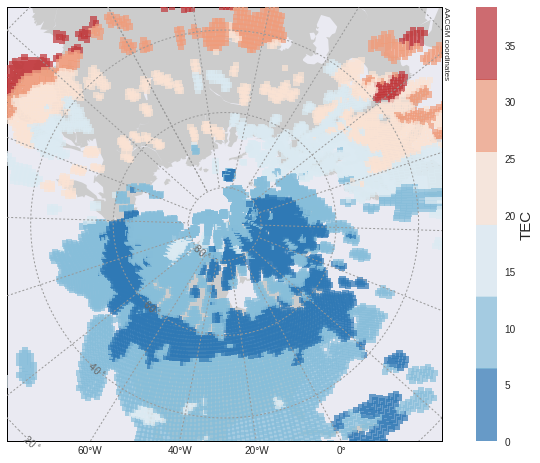

In [7]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("RdBu_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords='mag', ax=ax, datetime=nrstTime)
xVec, yVec = m1(list(newTECDF["mlon"]), list(newTECDF["mlat"]), coords="mag")
tecPlot = m1.scatter( xVec, yVec , c=newTECDF["tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s" )

cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)
f.savefig("../figs/tec-med-filt-" + nrstTime.strftime("%Y%m%d-%H%M") + ".pdf",bbox_inches='tight')
# set colorbar
# seaMap = ListedColormap(sns.color_palette("RdBu_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
# f = plt.figure(figsize=(12, 8))
# ax = f.add_subplot(1,1,1)
# m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords='geo', ax=ax, datetime=nrstTime)
# xVec, yVec = m1(list(newTECDF["glon"]), list(newTECDF["gdlat"]), coords="geo")
# tecPlot = m1.scatter( xVec, yVec , c=newTECDF["tec"], s=40.,\
#            cmap=seaMap, alpha=0.7, zorder=5., \
#                      edgecolor='none', marker="s" )

# cbar = plt.colorbar(tecPlot, orientation='vertical')
# cbar.set_label('TEC', size=15)
# f.savefig("../figs/tec-med-filt-" + nrstTime.strftime("%Y%m%d-%H%M") + ".pdf",bbox_inches='tight')

In [38]:
glonList = newTECDF["glon"].tolist()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")

BndGlonArr = []
BndMlonArr = []
BndEquGlatArr = []
BndPolGlatArr = []
minTecGlatArr = []
BndEquMlatArr = []
BndPolMlatArr = []
minTecMlatArr = []
BndEquMlonArr = []
BndPolMlonArr = []
minTecMlonArr = []
minTecValArr = []

for currGLon in glonList:
    selDF = newTECDF[ (newTECDF["glon"] == currGLon) &\
                     (newTECDF["mlat"] >= 40.0) &\
                     (~newTECDF["tec"].isnull()) &\
                     (newTECDF["mlat"] <= 70.0)]
    latArr = selDF["gdlat"].values
    mlatArr = selDF["mlat"].values
    tecArr = selDF["tec"].values
    # If number of values at a particular longitude is low,
    # discard it!
    if len( tecArr ) < 5. :
        continue
    filtTecArr = ndimage.filters.gaussian_filter1d(tecArr,2) #
    diffTecArr = numpy.gradient(numpy.gradient(filtTecArr))#numpy.gradient(numpy.gradient(filtTecArr))#numpy.gradient(filtTecArr)

    minTroughLocTec = numpy.argmin(filtTecArr)
    # minTroughLocTec is the location of the deepest point of 
    # the TEC trough! Now we need to find the zero crossing locations
    # one simple way to do this is to check for signs of the values
    # in the diffTecArr array, i.e., implement numpy.sign(). Now wherever
    # there is a zero crossing, we'll find numpy.diff() of this sign array
    # would be either +/- 2 depending on the direction of the crossing. Now
    # equatorward of the bottom trough loc, we should find the closest place
    # where value is +2 ( 1 - (-1) ) and vice versa for poleward boundary! Remember
    # we are looking at the second order derivatives!
    diffSignTecArr = numpy.diff( numpy.sign( diffTecArr ) )
    eqBndLocVals = numpy.where( diffSignTecArr == 2 )
    polBndLocVals = numpy.where( diffSignTecArr == -2 )
    eqBndLoc = -1.
    polBndLoc = -1.
    for eq in eqBndLocVals[0]:
        if eqBndLoc == -1 :
            if eq < minTroughLocTec:
                eqBndLoc = eq
        else:
            if eq < minTroughLocTec:
                if eq > eqBndLoc:
                    eqBndLoc = eq
    for po in polBndLocVals[0]:
        if polBndLoc == -1 :
            if po > minTroughLocTec:
                polBndLoc = po
        else:
            if po > minTroughLocTec:
                if po < polBndLoc:
                    polBndLoc = po
    # adjust poleward location of the boundary!
    # remember for numpy.diff we loose one element in the array
    if polBndLoc != -1:
        polBndLoc += 1 
    if ( (polBndLoc == -1) | (eqBndLoc == -1) ) :
        continue
    # Convert the coords to mlat and mlon
    currEqMlon, currEqMlat = utils.coord_conv( currGLon, latArr[eqBndLoc], \
                                 "geo", "mag", altitude=300., \
                                 date_time=nrstTime )
    currPoMlon, currPoMlat = utils.coord_conv( currGLon, latArr[polBndLoc], \
                                 "geo", "mag", altitude=300., \
                                 date_time=nrstTime )
    currMinTrghMlon, currMinTrghMlat = utils.coord_conv( currGLon, latArr[minTroughLocTec], \
                                 "geo", "mag", altitude=300., \
                                 date_time=nrstTime )
    BndGlonArr.append( currGLon )
    BndEquGlatArr.append( latArr[eqBndLoc] )
    BndPolGlatArr.append( latArr[polBndLoc] )
    minTecGlatArr.append( latArr[minTroughLocTec] )
    BndEquMlonArr.append( currEqMlon )
    BndEquMlatArr.append( currEqMlat )
    BndPolMlonArr.append( currPoMlon )
    BndPolMlatArr.append( currPoMlat )
    minTecMlonArr.append( currMinTrghMlon )
    minTecMlatArr.append( currMinTrghMlat )
    minTecValArr.append( tecArr[minTroughLocTec] )

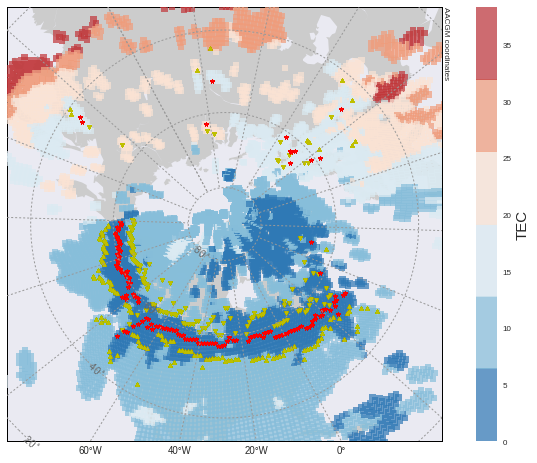

In [42]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("RdBu_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords='mag', ax=ax, datetime=nrstTime)
xVec, yVec = m1(list(newTECDF["mlon"]), list(newTECDF["mlat"]), coords="mag")
xVecEquBnd, yVecEquBnd = m1(BndEquMlonArr, BndEquMlatArr, coords="mag")
xVecPolBnd, yVecPolBnd = m1(BndPolMlonArr, BndPolMlatArr, coords="mag")
xVecMinTrghBnd, yVecMinTrghBnd = m1(minTecMlonArr, minTecMlatArr, coords="mag")
tecPlot = m1.scatter( xVec, yVec , c=newTECDF["tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s" )
eqPlot = m1.scatter( xVecEquBnd, yVecEquBnd , s=10.,\
                     c='y', marker="^", zorder=7. )
poPlot = m1.scatter( xVecPolBnd, yVecPolBnd , s=10.,\
                     c='y', marker="v", zorder=7. )
mtPlot = m1.scatter( xVecMinTrghBnd, yVecMinTrghBnd , s=15.,\
                     c='r', marker="*", zorder=7. )
cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)
f.savefig("../figs/trough-loc-" + nrstTime.strftime("%Y%m%d-%H%M") + ".pdf",bbox_inches='tight')

In [ ]:
# fig1 = plt.figure()
# ax1 = fig1.add_subplot(311)
# ax2 = fig1.add_subplot(312)
# ax3 = fig1.add_subplot(313)

# ax1.plot( latArr, tecArr, "." )
# ax1.plot( latArr, tecArr, "-" )
# ax1.scatter( latArr[eqBndLoc], tecArr[eqBndLoc],\
#             s=150, marker = "^", c= "r" )
# ax1.scatter( latArr[polBndLoc], tecArr[polBndLoc],\
#             s=150, marker = "v", c= "r" )

# ax2.plot( latArr, filtTecArr, "." )
# ax2.plot( latArr, filtTecArr, "-" )
# ax2.scatter( latArr[eqBndLoc], filtTecArr[eqBndLoc],\
#             s=100, marker = "^", c= "r" )
# ax2.scatter( latArr[polBndLoc], filtTecArr[polBndLoc],\
#             s=100, marker = "v", c= "r" )

# ax3.plot( latArr, diffTecArr, "." )
# ax3.plot( latArr, diffTecArr, "-" )
# ax3.scatter( latArr[eqBndLoc], diffTecArr[eqBndLoc],\
#             s=100, marker = "^", c= "r" )
# ax3.scatter( latArr[polBndLoc], diffTecArr[polBndLoc],\
#             s=100, marker = "v", c= "r" )

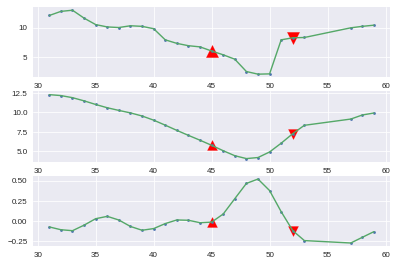